# Experimenting with the NASnet CNN Architecture to classify melanoma images as Benign or Malignant

This was developed using Juypter Notebooks on my local computer, not on Google Colab. This was because Google Drive could not handle the large number of files in the training and testing sets and was causing a lot of instability.

## Experiment 3
- 50% dropout layer
- Data augmentation
    - Pixel rescale (pixel normalisation)
    - rotation
    - horizontal flip
    - vertical flip
    - brightness_range
    - shear_range
- Transfer learning using imagenet
- Batch size 60
- 200 epoches

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import load_model

In [15]:
def plotAccAndVal(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 100
epochs = 50

In [10]:
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

train_aug_generator = train_aug_datagen.flow_from_directory(
        "./train",  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary'
)

Found 700 images belonging to 2 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    "./validation",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary"
)

Found 234 images belonging to 2 classes.


In [12]:
test_generator = validation_datagen.flow_from_directory(
    "./test",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 234 images belonging to 2 classes.


In [19]:
checkpoint_directory1 = "./saved_models/experiment_3/max_val_acc/epoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
checkpoint1 = ModelCheckpoint(checkpoint_directory1, monitor="val_acc", verbose=1, save_best_only="max")

checkpoint_directory2 = "./saved_models/experiment_3/min_val_loss/epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5"
checkpoint2 = ModelCheckpoint(checkpoint_directory2, monitor="val_loss", verbose=1, save_best_only="min")

callbacks_list = [checkpoint1, checkpoint2]

In [20]:
nas_net = NASNetMobile(
    weights="imagenet", 
    include_top=False, 
    input_shape=(224, 224, 3),
    pooling="max"
)

model_e3 = tf.keras.models.Sequential()
model_e3.add(nas_net)
model_e3.add(tf.keras.layers.Dropout(0.5))
model_e3.add(tf.keras.layers.Flatten())
model_e3.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_e3.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_e3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model_e3.summary()

model_e3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    metrics=['acc']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 1056)              4269716   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1056)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 224)               236768    
_________________________________________________________________
dense_4 (Dense)              (None, 224)               50400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 225       
Total params: 4,557,109
Trainable params: 4,520,371
Non-trainable params: 36,738
_______________________________________

In [22]:
experiment3 = model_e3.fit(
    train_aug_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/50
7/7 - 90s - loss: 0.7892 - acc: 0.6100 - val_loss: 0.7766 - val_acc: 0.5940

Epoch 00001: val_acc improved from 0.52137 to 0.59402, saving model to ./saved_models/experiment_3/max_val_acc\epoch-01-val_acc-0.59.hdf5

Epoch 00001: val_loss improved from 1.04468 to 0.77656, saving model to ./saved_models/experiment_3/min_val_loss\epoch-01-val_loss-0.78.hdf5
Epoch 2/50
7/7 - 90s - loss: 0.6843 - acc: 0.6543 - val_loss: 0.8832 - val_acc: 0.5470

Epoch 00002: val_acc did not improve from 0.59402

Epoch 00002: val_loss did not improve from 0.77656
Epoch 3/50
7/7 - 90s - loss: 0.7222 - acc: 0.6557 - val_loss: 0.8200 - val_acc: 0.5556

Epoch 00003: val_acc did not improve from 0.59402

Epoch 00003: val_loss did not improve from 0.77656
Epoch 4/50
7/7 - 89s - loss: 0.6450 - acc: 0.6843 - val_loss: 0.7460 - val_acc: 0.6068

Epoch 00004: val_acc improved from 0.59402 to 0.60684, saving model to ./saved_models/experiment_3/max_val_acc\epoch-04-val_acc-0.61.hdf5

Epoch 00004: val_loss imp

7/7 - 90s - loss: 0.2598 - acc: 0.8886 - val_loss: 0.7979 - val_acc: 0.5726

Epoch 00036: val_acc did not improve from 0.69658

Epoch 00036: val_loss did not improve from 0.64643
Epoch 37/50
7/7 - 90s - loss: 0.2814 - acc: 0.8643 - val_loss: 0.7885 - val_acc: 0.5769

Epoch 00037: val_acc did not improve from 0.69658

Epoch 00037: val_loss did not improve from 0.64643
Epoch 38/50
7/7 - 90s - loss: 0.2531 - acc: 0.8886 - val_loss: 0.8029 - val_acc: 0.5641

Epoch 00038: val_acc did not improve from 0.69658

Epoch 00038: val_loss did not improve from 0.64643
Epoch 39/50
7/7 - 91s - loss: 0.2592 - acc: 0.8900 - val_loss: 0.8495 - val_acc: 0.5598

Epoch 00039: val_acc did not improve from 0.69658

Epoch 00039: val_loss did not improve from 0.64643
Epoch 40/50
7/7 - 90s - loss: 0.2134 - acc: 0.9129 - val_loss: 0.8876 - val_acc: 0.5556

Epoch 00040: val_acc did not improve from 0.69658

Epoch 00040: val_loss did not improve from 0.64643
Epoch 41/50
7/7 - 90s - loss: 0.2254 - acc: 0.9029 - val_

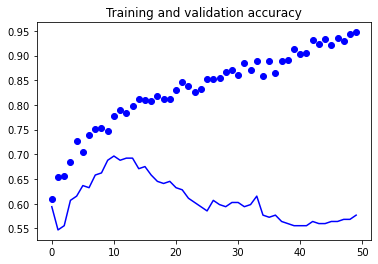

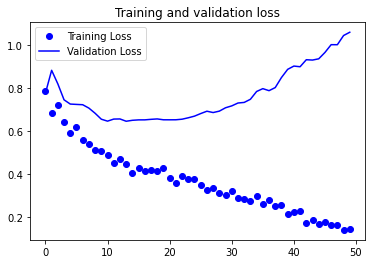

In [23]:
plotAccAndVal(experiment3)

In [33]:
probabilities = model_e3.predict(test_generator, 234)

In [66]:
y_true = np.array([0] * 117 + [1] * 117)
y_pred = probabilities > 0.5

confusionMatrix = confusion_matrix(y_true, y_pred)

In [67]:
def visualiseConfusionMatrix(confusionMatrix, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confusionMatrix, 
        annot=True, 
        fmt=".3f", 
        linewidths=.75, 
        square = True, 
        cmap = "Blues_r",
        xticklabels=["Benign", "Malignant"],
        yticklabels=["Benign", "Malignant"]
    )
    plt.ylabel("Actual classification")
    plt.xlabel("Predicted predicted")
    plt.title(title, size = 15)

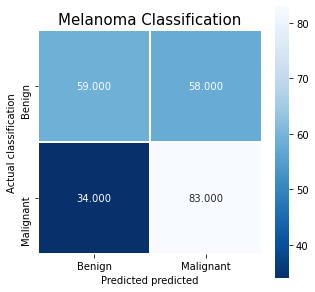

In [68]:
visualiseConfusionMatrix(confusionMatrix, "Melanoma Classification")

In [70]:
confusionMatrix

array([[59, 58],
       [34, 83]], dtype=int64)

A positive in this experiment is a sample being classified as benign. So a false positive is a case being classified by our model as being benign when it was actually malignant.

In [75]:
fpr = confusionMatrix[1][0] / (confusionMatrix[1][0] + confusionMatrix[1][1])
print(f"FPR: {round(fpr*100, 2)}%")

FPR: 29.06%


In [80]:
test_accuracy = (confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0] + confusionMatrix[1][1])
print(f"Test accuracy: {round(test_accuracy*100, 2)}%")

Test accuracy: 60.68%
